# Práctica 9: Patrones de Representación de Datos

Inteligencia de Datos

Universidad Iberoamericana Ciudad de México

Creado por: Luis Norberto Zúñiga Morales, inspirado en el libro *Machine Learning Design Patterns*.

## Escalar datos funciona

En este pequeño código vamos a medir el impacto de escalar linealmente los datos en un modelo de regresión lineal. Primero, importamos las librerías necesarias y cargamos los datos: en esta ocasión usaremos el conjunto de datos diabetes.

In [1]:
from sklearn import datasets, linear_model
import timeit

In [2]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
raw = diabetes_X[:, None, 2]

Después, transformamos los datos para que se encuentren en el rango $[-1,1]$ mediante min-max scaling de forma manual:

In [3]:
max_raw = max(raw)
min_raw = min(raw)
scaled = (2*raw - max_raw - min_raw)/(max_raw - min_raw)

Definimos dos funciones para entrenar los modelos con nuestros datos, la primera con los datos originales y la segunda con los datos transformados.

In [4]:
def train_raw():
    linear_model.LinearRegression().fit(raw, diabetes_y)

def train_scaled():
    linear_model.LinearRegression().fit(scaled, diabetes_y)

Finalmente, calculamos el tiempo que toma entrenar los modelos con el método `timeit`:

In [5]:
raw_time = timeit.timeit(train_raw, number=1000)
scaled_time = timeit.timeit(train_scaled, number=1000)
print('Sin cambios: {:.4f}s, Con Escala: {:.4f}s, Mejora: {:2f}%'
      .format(raw_time, scaled_time, 100*(raw_time-scaled_time)/raw_time))

Sin cambios: 1.2915s, Con Escala: 2.3615s, Mejora: -82.852985%


**Actividad**: ¿Qué hace el método `timeit` con el parámetro `number=1000`?

*Su respuesta aquí*

**Ejercicio #1**: Vimos que al transformar los datos existe una mejora de tiempo al entrenar los modelos. ¿Existirá una mejora en el rendimiento de los modelos? Entrenar los modelos anteriores para obtener el ECM y determinar si existe mejora alguna entre el modelo entrenado con los datos originales y el modelo entrenado con los datos transformados.

In [ ]:
# su código en esta celda

## Variables numéricas

En esta sección vamos a trabajar con un conjunto de datos cuyo fin es determinar el peso de un bebé al nacer dadas distintas características. Originalmente, tendríamos que usar Big Query para obtener los datos, pero por lo incómodo que puede ser para algunos, vamos a usar un pequeño subconjunto de datos.

Vamos a empezar importando las librerías necesarias y cargando los datos a la sesión:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df_train = pd.read_csv('babyweight_train.csv')
df_val = pd.read_csv('babyweight_eval.csv')

In [ ]:
df = pd.concat([df_train, df_val])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329701 entries, 0 to 65136
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   weight_pounds    329701 non-null  float64
 1   is_male          329701 non-null  bool   
 2   mother_age       329701 non-null  int64  
 3   plurality        329701 non-null  object 
 4   gestation_weeks  329701 non-null  int64  
 5   mother_race      231451 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 15.4+ MB


In [ ]:
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race
0,7.749249,False,12,Single(1),40,1.0
1,7.561856,True,12,Single(1),40,2.0
2,7.187070,False,12,Single(1),34,3.0
3,6.375769,True,12,Single(1),36,2.0
4,7.936641,False,12,Single(1),35,NaN


In [ ]:
df['mother_race'].unique()

array([ 1.,  2.,  3., nan, 68., 78.,  7.,  5.,  9.,  4., 18., 38.,  6.,
       58., 48., 28.])

Graficamos la edad de la madre contra el promedio del peso de los bebés:

<ipython-input-18-ec576ccd0f45>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by=['mother_age']).mean().plot(y='weight_pounds')


Text(0.5, 1.0, 'mother_age vs avg_weight')

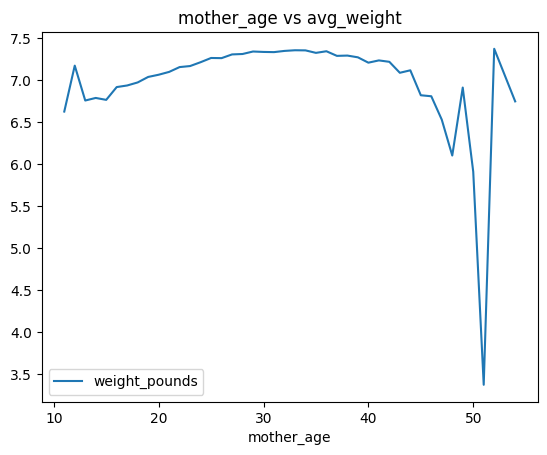

In [ ]:
df.groupby(by=['mother_age']).mean().plot(y='weight_pounds')
plt.title('mother_age vs avg_weight')

Determinamos la frecuencia de nacimientos según la edad de la madre:

Text(0, 0.5, 'Frecuencia')

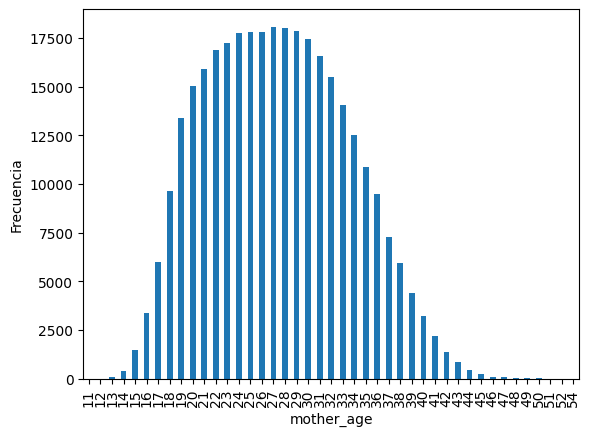

In [ ]:
df['mother_age'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('mother_age')
plt.ylabel('Frecuencia')

**Pregunta**: ¿Vale la pena eliminar a las madres de más de 50 o menos de 14 años? ¿Es válido?

Ahora, vamos a aplicar las transformaciones lineales de los datos que vimos en la presentación:

In [ ]:
def min_max_scaling(x, max_x, min_x):
  return (2*x-max_x-min_x)/(max_x-min_x)

def z_score(x, x_mean, x_stddev):
  return (x-x_mean)/x_stddev

def mean_normalization(x, x_mean, max_x, min_x):
  return (x-x_mean)/(max_x-min_x)

Aplicamos las transformaciones anteriores en el `DataFrame` mediante `apply` y funciones lambda, creando nuevas columnas para los nuevos datos de `mother_age` transformados y los graficamos para comparación. Noten que esto puede tardar *varios* minutos.

In [ ]:
df['min_max'] = df['mother_age'].apply(lambda x: min_max_scaling(x, df['mother_age'].max(), df['mother_age'].min()))
df['z_score'] = df['mother_age'].apply(lambda x: z_score(x, df['mother_age'].mean(), df['mother_age'].std()))
df['mean_norm'] = df['mother_age'].apply(lambda x: mean_normalization(x, df['mother_age'].mean(), df['mother_age'].max(), df['mother_age'].min()))
df['clipped'] = df['mother_age'].apply(lambda x: (x - 30)/15).clip(-1,1)

<Axes: xlabel='mother age', ylabel='Frecuencia'>

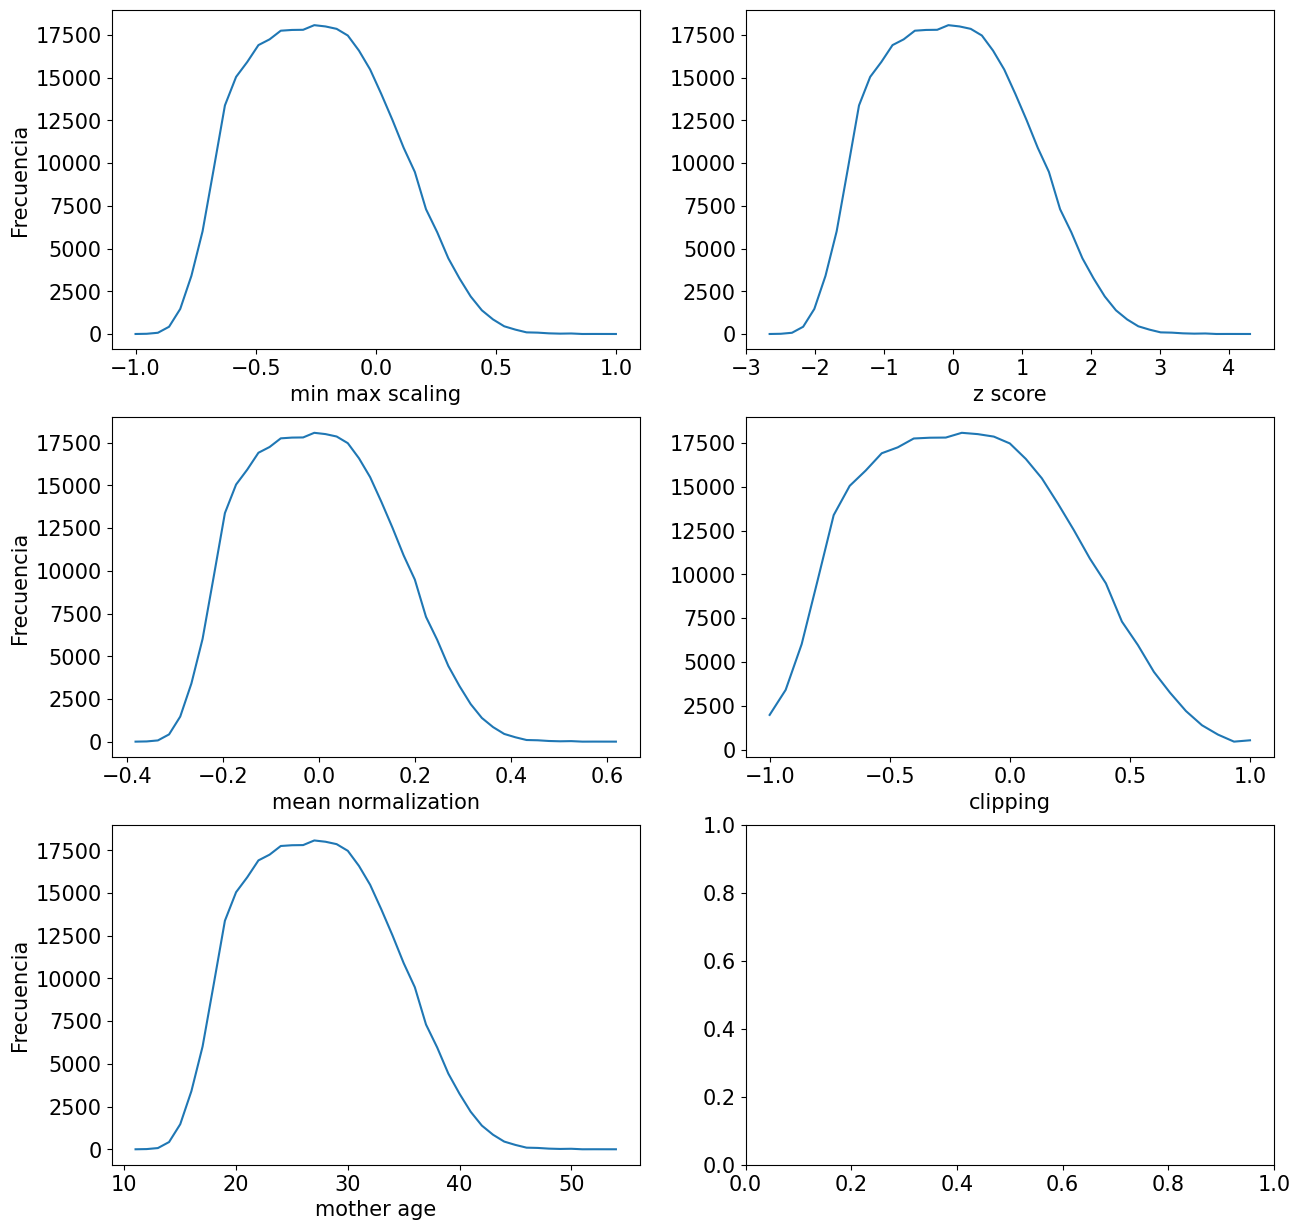

In [ ]:
labels = ['min_max', 'z_score', 'mean_norm', 'clipped']
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3, 2);
df['min_max'].value_counts().sort_index().plot(ax=axs[0, 0], xlabel='min max scaling', ylabel='Frecuencia')
df['z_score'].value_counts().sort_index().plot(ax=axs[0, 1], xlabel='z score')
df['mean_norm'].value_counts().sort_index().plot(ax=axs[1, 0], xlabel='mean normalization', ylabel='Frecuencia')
df['clipped'].value_counts().sort_index().plot(ax=axs[1, 1], xlabel='clipping')
df['mother_age'].value_counts().sort_index().plot(ax=axs[2, 0], xlabel='mother age', ylabel='Frecuencia')

**Pregunta**: ¿Qué pueden observar de las gráficas anteriores? ¿Prefieren alguna para entrenar un modelo de ML en particular? ¿Por qué?

## Hashing en Pandas

Podemos usar el método `hash_array` en pandas para aplicar el hashing a una columna de texto. Por ejemplo, consideren lo siguiente:

In [ ]:
df_h = pd.DataFrame({'a': ['asds', 'asdds', 'asdsadsdas']})

In [ ]:
df_h['hash'] = pd.util.hash_array(df_h['a'].to_numpy())

In [ ]:
df_h.head()

,a,hash
0,asds,12904087005762419380
1,asdds,2291595230012760629
2,asdsadsdas,658070067201230184


Falta dividirlos en cubetas. Supongamos que queremos repartirlos en dos:

In [ ]:
n_buckets = 2
df_h['bucket'] = df_h['hash'].apply(lambda x: x%n_buckets)

In [ ]:
df_h.head()

,a,hash,bucket
0,asds,12904087005762419380,0
1,asdds,2291595230012760629,1
2,asdsadsdas,658070067201230184,0


## Actividades

1. Del conjunto de datos de los bebés, determinen cuales variables categóricas necesitan aplicárseles one-hot-encoding para que puedan usarse correctamente en un modelo de aprendizaje. Después, apliquen esa transformación e impriman los primeros cinco datos para mostrar como resulta el `DataFrame` final.

2. La columna `is_male` adopta valores de `True` o `False`. Modifiquen la columna para que contenga valores numéricos.

3. Realizar lo mismo para `plurality`. ¿Creen que esta columna es categórica o numérica? ¿Vale la pena considerarla como la contraria?

4. Apliquen una estrategia para manejar los datos faltantes de las columnas.